# Benchmarking Qmachines with different RB protocols

In [1]:
from functions import *
from pyquil import get_qc
from pyquil import noise

In [2]:
%%capture
from tqdm import tqdm_notebook as tqdm
tqdm().pandas() #This line make sure that the progress bars looks natural

In [3]:
import matplotlib.pyplot as plt
import os
import numpy as np
import seaborn as sns

In [4]:
from scipy.optimize import curve_fit

In [5]:
from csv import writer
import _pickle as cPickle
from datetime import datetime

In [6]:
k_m = 200 #number of sequences
n_m = 500 #number of shots

target_qubits = [0]
n_qubit = len(target_qubits)

# qmachine = get_qc("Aspen-M-3")
qmachine = get_qc( str(n_qubit) + 'q-qvm')  # You can make any 'nq-qvm'

### Depolarising noise in terms of pauli channels
$$ \Lambda_{dep}(\rho) = (1-3\lambda/4)\rho + \lambda/4 X^{\dagger}\rho X + \lambda/4 Y^{\dagger}\rho Y + \lambda/4 Z^{\dagger}\rho Z $$

$$ \Lambda_{dep}(\rho) = (1-\epsilon)\rho + \frac{\epsilon}{d} I $$

So if we want to have a depolarising noise channel with $\epsilon = 0.0001$, we should define it with taking into account that $p_i = \frac{\epsilon}{4} $. So it gives

$p_i \approx 0.000025 $

In [7]:
epsilon = 0.01
p_xi = epsilon/4
qmachine.qam.gate_noise=(p_xi,p_xi,p_xi)
# qmachine.qam.gate_noise=(0.005,0.010,0.015)
# qmachine.qam.gate_noise=(0,0,p_xi)

In [8]:
# noisy_machine = qmachine.name
noisy_machine = 'depolarising_noise' + '_epsilon{}'.format(epsilon)
# noisy_machine = 'pauli_stochastic_noise'
path = os.path.join( os.getcwd(), 'output_storage', noisy_machine)
try:
    os.makedirs( path )
except:
    pass

In [9]:
ordered_layers = np.arange(2,30,2).astype('int')

ordered_layers_arr = np.array( ordered_layers )
between_layers = np.arange(ordered_layers_arr.min(),ordered_layers_arr.max()+1,1).astype('int')

# bench_protocol_func_dict = {'standard':machine_response_standard_bench,
#                             'native':machine_response_srb_native_gate,
#                             'native_conditional':machine_response_rb_native_gate_conditional_single_qubit,
#                             'stabilizer':machine_response_stabilizer_bench,
#                             'random_def_unitaries':machine_response_standard_bench_random_units,
#                            'conditional_universal_circuit':machine_response_rb_universal_two_qubits_conditional}

In [10]:
bench_protocol_func_dict = {'native_conditional_single_qubit':native_rigetti_single_qubit_packs_generator,
                           'native_conditional_conditional_two_qubits':native_universal_two_qubits_packs_generator}

In [11]:
sns.set_theme(context='paper', font= 'Serif', style = 'ticks')

In [12]:
file_path = os.path.join(path, '{}.csv'.format(qmachine.name))
if os.path.isfile(file_path):
    pass
else:
    with open(file_path, 'w') as f_object:
        writer_object = writer(f_object)
        writer_object.writerow(['date', 'target qubits', 'number of sequences', 'number of shots',
                                'protocol name', 'circuit depth', 'average of fidelity', 'error of fidelity'])
        f_object.close()

In [13]:
def record_this_layer(protocol_name:str, qmachine, depth:int, fidelity_average, fidelity_err):
    List = [datetime.today().strftime('%Y-%m-%d'), target_qubits, k_m, n_m,
            protocol_name, depth, fidelity_average, fidelity_err]
    file_path = os.path.join(path, '{}.csv'.format(qmachine.name))
    with open(file_path, 'a') as f_object:
        writer_object = writer(f_object)
        writer_object.writerow(List)
        f_object.close()
    return

# def save_experiment(experiment, protocol_name, target_qubits, layer_num, num_of_sequences):
#     path = os.path.join( os.getcwd(), 'experiments_warehouse', protocol_name, str(target_qubits))
#     try:
#         os.makedirs( path )
#     except:
#         pass
    
#     file_path = os.path.join( path, 'L{}_K{}.pickle'.format(layer_num, num_of_sequences) )
    
#     with open(file_path, "wb") as output_file:
#         cPickle.dump(experiment, output_file)
#     return

In [14]:
def bench_machine(protocol_name:str, qmachine, target_qubits:list, k_m:int, n_m:int):
    bench_protocol_func = bench_protocol_func_dict[protocol_name]
    avg_fdlty_list = []
    err_fdlty_list = []
    
    for m in tqdm(ordered_layers):
        exps = catch_experiments(qmachine, target_qubits = target_qubits,
                                    protocol_name=protocol_name,
                                    layers_num=m, exp_num=k_m)
#         save_experiment(exps, protocol_name, target_qubits, m, k_m)
        
        response = find_machine_response(qmachine, exps, n_m)
        record_this_layer(protocol_name, qmachine, m, averageOfFidelity(response), stdOfFidelity(response))
        
        avg_fdlty_list.append( averageOfFidelity(response) )
        err_fdlty_list.append( stdOfFidelity(response) )
    return np.array(avg_fdlty_list), np.array(err_fdlty_list)

In [15]:
def prepare_experiments(protocol_name:str, qmachine, target_qubits:list, k_m:int, n_m:int):
    bench_protocol_func = bench_protocol_func_dict[protocol_name]
    
    for m in tqdm(ordered_layers):
        exps = generate_experiments(qmachine, target_qubits = target_qubits,
                                    circuit_gen_func=bench_protocol_func,
                                    layers_num=m, exp_num=k_m)
        save_experiment(exps, protocol_name, target_qubits, m, k_m)
    return 

## RB stabilizer version (with Clifford set)

In [ ]:
# avg_stab_fdlty_arr, err_stab_fdlty_arr = bench_machine('stabilizer', qmachine, n_qubit, k_m, n_m)

# popt_stab, pcov_stab = extrapolate_decay_func(avg_stab_fdlty_arr, err_stab_fdlty_arr)
# plot_decay(ordered_layers_arr, avg_stab_fdlty_arr, err_stab_fdlty_arr, 'stabilizer_clifford')

## RB standard version (with Riggetti native gate set)

In [ ]:
# avg_native_fdlty_arr, err_native_fdlty_arr = bench_machine('native', qmachine, n_qubit, k_m, n_m)

# # popt_native, pcov_native = extrapolate_decay_func(avg_native_fdlty_arr, err_native_fdlty_arr)
# plot_decay(ordered_layers_arr, avg_native_fdlty_arr, err_native_fdlty_arr, 'random_native_gates')

## RB standard version (with arbitary random unitary set)

In [ ]:
# avg_runitary_fdlty_arr, err_runitary_fdlty_arr = bench_machine('random_def_unitaries', qmachine, n_qubit, k_m, n_m)

# # popt_runitary, pcov_runitary = extrapolate_decay_func(avg_runitary_fdlty_arr, err_runitary_fdlty_arr)
# plot_decay(ordered_layers_arr, avg_runitary_fdlty_arr, err_runitary_fdlty_arr, 'random_unitary_gates')

# single-qubit RB with conditional prob. on native gates

In [17]:
prepare_experiments('native_conditional_single_qubit', qmachine, target_qubits, k_m, n_m)

C:\Users\mohsen\AppData\Local\Temp\ipykernel_8164\1121408283.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for m in tqdm(ordered_layers):


  0%|          | 0/14 [00:00<?, ?it/s]

exp. generation:   0%|          | 0/200 [00:00<?, ?it/s]

exp. generation:   0%|          | 0/200 [00:00<?, ?it/s]

exp. generation:   0%|          | 0/200 [00:00<?, ?it/s]

exp. generation:   0%|          | 0/200 [00:00<?, ?it/s]

exp. generation:   0%|          | 0/200 [00:00<?, ?it/s]

exp. generation:   0%|          | 0/200 [00:00<?, ?it/s]

exp. generation:   0%|          | 0/200 [00:00<?, ?it/s]

exp. generation:   0%|          | 0/200 [00:00<?, ?it/s]

exp. generation:   0%|          | 0/200 [00:00<?, ?it/s]

exp. generation:   0%|          | 0/200 [00:00<?, ?it/s]

exp. generation:   0%|          | 0/200 [00:00<?, ?it/s]

exp. generation:   0%|          | 0/200 [00:00<?, ?it/s]

exp. generation:   0%|          | 0/200 [00:00<?, ?it/s]

exp. generation:   0%|          | 0/200 [00:00<?, ?it/s]

C:\Users\mohsen\AppData\Local\Temp\ipykernel_8164\4003176086.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for m in tqdm(ordered_layers):


  0%|          | 0/14 [00:00<?, ?it/s]

Examing the seq.:   0%|          | 0/200 [00:00<?, ?it/s]

Examing the seq.:   0%|          | 0/200 [00:00<?, ?it/s]

Examing the seq.:   0%|          | 0/200 [00:00<?, ?it/s]

Examing the seq.:   0%|          | 0/200 [00:00<?, ?it/s]

Examing the seq.:   0%|          | 0/200 [00:00<?, ?it/s]

Examing the seq.:   0%|          | 0/200 [00:00<?, ?it/s]

Examing the seq.:   0%|          | 0/200 [00:00<?, ?it/s]

Examing the seq.:   0%|          | 0/200 [00:00<?, ?it/s]

Examing the seq.:   0%|          | 0/200 [00:00<?, ?it/s]

Examing the seq.:   0%|          | 0/200 [00:00<?, ?it/s]

Examing the seq.:   0%|          | 0/200 [00:00<?, ?it/s]

Examing the seq.:   0%|          | 0/200 [00:00<?, ?it/s]

Examing the seq.:   0%|          | 0/200 [00:00<?, ?it/s]

Examing the seq.:   0%|          | 0/200 [00:00<?, ?it/s]

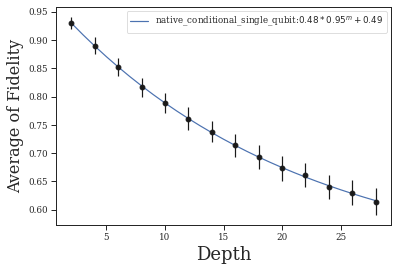

In [18]:
avg_cond_fdlty_arr, err_cond_fdlty_arr = bench_machine('native_conditional_single_qubit', qmachine, [0], k_m, n_m)

plot_decay(ordered_layers_arr, avg_cond_fdlty_arr, err_cond_fdlty_arr, 'native_conditional_single_qubit')

In [ ]:
avg_cond_fdlty_arr, err_cond_fdlty_arr

# RB with conditional prob. on two qubits

In [ ]:
#Classical compilation process
prepare_experiments('native_conditional_conditional_two_qubits', qmachine, target_qubits, k_m, n_m)

In [ ]:
avg_cond_fdlty_arr, err_cond_fdlty_arr = bench_machine('native_conditional_conditional_two_qubits', qmachine, target_qubits, k_m, n_m)
plot_decay(ordered_layers_arr, avg_cond_fdlty_arr, err_cond_fdlty_arr, ' native_conditional_conditional_two_qubits')

In [ ]:
avg_cond_fdlty_arr

In [ ]:
err_cond_fdlty_arr

## RB standard version (with Clifford set)

In [ ]:
prepare_experiments('standard_rb_single_qubit', qmachine, target_qubits, k_m, n_m)

In [ ]:
avg_cond_fdlty_arr, err_cond_fdlty_arr = bench_machine('standard_rb_single_qubit', qmachine, target_qubits, k_m, n_m)
plot_decay(ordered_layers_arr, avg_cond_fdlty_arr, err_cond_fdlty_arr, 'standard_rb_single_qubit')

## Diamond distance

In [ ]:
fig = plt.figure(dpi = 800)
ax = fig.add_subplot()

plot_decay(ordered_layers_arr[1:], avg_cond_fdlty_arr[1:], err_cond_fdlty_arr[1:],
           ' conditional_universal_circuit', axes = ax)

plt.xlabel('Depth', fontsize=18)
plt.ylabel('Average of Fidelity', fontsize=16)
plt.title(r'RB versions comparison ($\epsilon = {}$)'.format(epsilon))

plt.legend()

# fig.savefig('RB_comparison.png')

r parameter for Native gateset

In [ ]:
decay_param(popt_native[0], n_qubit)

r parameter for Clifford gateset

In [ ]:
decay_param(popt_std[0], n_qubit)

r parameter for Native benchmarking new method!

In [ ]:
decay_param(popt_cond[0], n_qubit)